In [1]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset -p /content/mango_leaf_disease --unzip


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 103M/103M [00:05<00:00, 23.5MB/s] 
100% 103M/103M [00:05<00:00, 19.1MB/s]


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
base_dir = '/content/mango_leaf_disease'

In [4]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [5]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 580ms/step - accuracy: 0.1570 - loss: 2.6185 - val_accuracy: 0.4325 - val_loss: 1.7376 - learning_rate: 1.0000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 484ms/step - accuracy: 0.3237 - loss: 1.9260 - val_accuracy: 0.6750 - val_loss: 1.3065 - learning_rate: 1.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 470ms/step - accuracy: 0.4729 - loss: 1.5058 - val_accuracy: 0.7325 - val_loss: 1.0028 - learning_rate: 1.0000e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 468ms/step - accuracy: 0.6014 - loss: 1.1761 - val_accuracy: 0.7937 - val_loss: 0.7833 - learning_rate: 1.0000e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 471ms/step - accuracy: 0.6613 - loss: 1.0158 - val_accuracy: 0.8225 - val_loss: 0.6814 - learning_rate: 1.0000e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 481ms/step - accuracy: 0.7266 - loss: 0.8420 - val_accuracy: 0.8275 - val_loss: 0.5921 - learning_rate: 1.0000e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 490ms/step - 

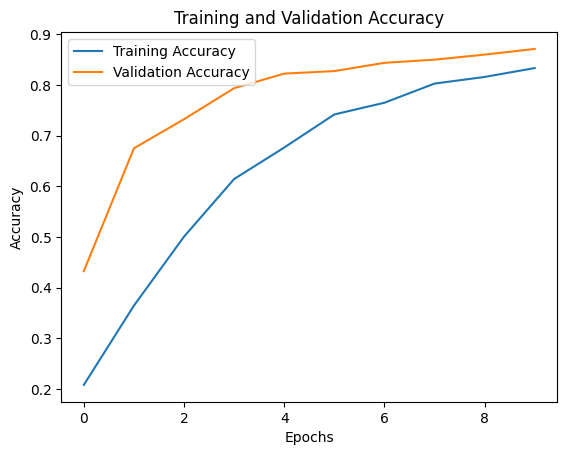

In [7]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')
plt.show()